In [2]:
import torch

In [3]:
torch.__version__

'2.0.1'

In [4]:
torch.manual_seed(42)

In [5]:
x = torch.rand(2, 3, 4)
x

tensor([[[0.8823, 0.9150, 0.3829, 0.9593],
         [0.3904, 0.6009, 0.2566, 0.7936],
         [0.9408, 0.1332, 0.9346, 0.5936]],

        [[0.8694, 0.5677, 0.7411, 0.4294],
         [0.8854, 0.5739, 0.2666, 0.6274],
         [0.2696, 0.4414, 0.2969, 0.8317]]])

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cpu


In [7]:
import torch
from torch import nn
import torch.nn.functional

In [8]:
class SimpleClassifier(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fun = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.act_fun(x)
        x = self.linear2(x)
        return x

In [9]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
print(model)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fun): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


In [10]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.5582, -0.3260],
         [-0.1997, -0.4252],
         [ 0.0667, -0.6984],
         [ 0.6386, -0.6007]], requires_grad=True),
 Parameter containing:
 tensor([ 0.5459,  0.1177, -0.2296,  0.4370], requires_grad=True),
 Parameter containing:
 tensor([[ 0.0779,  0.4040,  0.0547, -0.1577]], requires_grad=True),
 Parameter containing:
 tensor([0.1343], requires_grad=True)]

In [11]:
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

Parameter linear1.weight, shape torch.Size([4, 2])
Parameter linear1.bias, shape torch.Size([4])
Parameter linear2.weight, shape torch.Size([1, 4])
Parameter linear2.bias, shape torch.Size([1])


In [12]:
from torch.utils import data

In [13]:
class XORDataset(data.Dataset):
    def __init__(self, size, std=0.1):
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continous_xor()
        
    def generate_continous_xor(self):
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        data += self.std * torch.randn(data.shape)
        
        self.data = data
        self.label = label
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        data_point = self.data[idx]
        data_label = self.label[idx]
        
        return data_point, data_label

In [14]:
dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (tensor([0.1470, 0.8878]), tensor(1))


In [15]:
import matplotlib.pyplot as plt

In [16]:
def visualize_samples(data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4, 4))
    plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

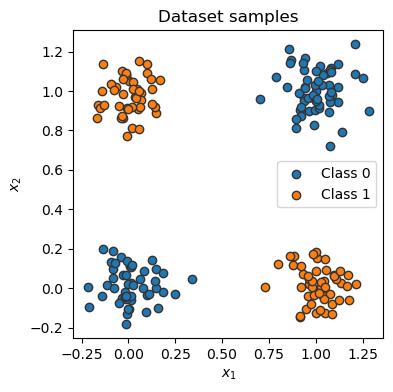

In [17]:
visualize_samples(dataset.data, dataset.label)
plt.show()

In [18]:
data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True)

In [19]:
loss_module = nn.BCEWithLogitsLoss()

In [20]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [21]:
train_dataset = XORDataset(size=1000)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [22]:
model.to(device)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fun): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

In [27]:
from tqdm.notebook import tqdm

In [41]:
def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    # set model in train mode
    model.train()
    
    # Training loop
    for epoch in range(num_epochs):
        for data_inputs, data_labels in data_loader:
            # Move data to GPU if available
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)
            
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            
            loss = loss_module(preds, data_labels.float())
            
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()
            optimizer.step()
    

In [42]:
train_model(model, optimizer, train_data_loader, loss_module)

In [43]:
state_dict = model.state_dict()
print(state_dict)

OrderedDict([('linear1.weight', tensor([[-1.8667, -1.6987],
        [ 0.1892, -1.0336],
        [ 2.2227, -2.7704],
        [ 3.3310, -2.9220]])), ('linear1.bias', tensor([ 0.2453,  0.3908, -1.0002,  1.3889])), ('linear2.weight', tensor([[-2.5393,  1.2370,  3.6318, -4.3716]])), ('linear2.bias', tensor([1.7852]))])


In [44]:
# torch.save(object, filename). For the filename, any extension can be used
# torch.save(state_dict, "our_model.tar")

In [45]:
# # Load state dict from the disk (make sure it is the same name as above)
# state_dict = torch.load("our_model.tar")

# # Create a new model and load the state
# new_model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
# new_model.load_state_dict(state_dict)

# # Verify that the parameters are the same
# print("Original model\n", model.state_dict())
# print("\nLoaded model\n", new_model.state_dict())

In [46]:
test_dataset = XORDataset(size=500)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)

In [53]:
def eval_model(model, data_loader):
    # set eval mode
    model.eval()
    true_preds, num_preds = 0.0, 0.0
    
    with torch.no_grad():
        for data_inputs, data_labels in data_loader:
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds)
            pred_labels = (preds >= 0.5).long()
            
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]
            
    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [54]:
eval_model(model, test_data_loader)

Accuracy of the model: 100.00%


In [59]:
from matplotlib.colors import to_rgba

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1684910934293/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


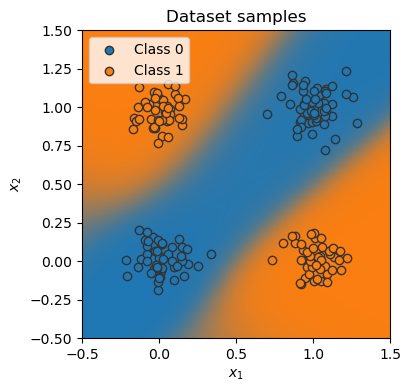

In [60]:
@torch.no_grad()  # Decorator, same effect as "with torch.no_grad(): ..." over the whole function.
def visualize_classification(model, data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4, 4))
    plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    # Let's make use of a lot of operations we have learned above
    model.to(device)
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2)  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    # Specifying "None" in a dimension creates a new one
    output_image = (1 - preds) * c0[None, None] + preds * c1[None, None]
    output_image = (
        output_image.cpu().numpy()
    )  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin="lower", extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)


visualize_classification(model, dataset.data, dataset.label)
plt.show()